# Spatial Correlation Matrix to AOA

This repo aims to learn the AOA of LoRa beacons from Spatial Correlation Matrix, R. Here is the nice article how support vector method (e.g, SVR) can also be used for regression.

https://www.saedsayad.com/support_vector_machine_reg.htm

In [1]:
import os
from os.path import join
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error
%matplotlib inline

## Preparation
Create dataset for training and testing from Rosbag recorded .csv file named as 'deg_(theta).csv'. Useful features lie in field 1, 2, 3, 6, 7, and 11 of the spatial correlation matrix, R.

In [2]:
data_dir = 'data'
aoa_dict = {}

for filename in os.listdir(data_dir):
    if filename.startswith("deg_"):
        aoa = pd.read_csv(join(data_dir, filename), sep=',', header=0)
        aoa_Rjk = aoa[['field.data1', 'field.data2', 'field.data3', 'field.data6', 'field.data7', 'field.data11']]
        aoa_dict[float(filename[4:-4])] = aoa_Rjk

In [3]:
aoa_dict[45].head()

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11
0,1.939971e-08,-4.248640e-08,-2.295504e-08,-2.056429e-07,-1.215965e-07,3.157838e-07
1,2.219311e-08,-4.225748e-08,-2.653648e-08,-1.911711e-07,-1.153880e-07,3.227424e-07
2,1.879340e-08,-4.313880e-08,-2.411608e-08,-1.945511e-07,-1.278674e-07,3.225406e-07
3,1.813206e-08,-4.317706e-08,-2.366060e-08,-1.884413e-07,-1.116011e-07,3.337128e-07
4,1.770188e-08,-4.351002e-08,-2.294230e-08,-1.805710e-07,-1.152730e-07,3.297267e-07


In [4]:
aoa_dict[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   field.data1   303 non-null    float64
 1   field.data2   303 non-null    float64
 2   field.data3   303 non-null    float64
 3   field.data6   303 non-null    float64
 4   field.data7   303 non-null    float64
 5   field.data11  303 non-null    float64
dtypes: float64(6)
memory usage: 14.3 KB


In [5]:
#Degree to Radian
for key in aoa_dict.keys():
    aoa_dict[key]['theta'] = key * math.pi / 180

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Show detection of LoRa beacon when Rjk is significant
aoa_dict[0][abs(aoa_dict[0]['field.data1']) > 1e-04]

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11,theta
79,0.012877,-0.009219,-0.010711,-0.065259,-0.077955,0.113721,0.0
80,0.011722,-0.008505,-0.009817,-0.060846,-0.071996,0.104349,0.0
81,0.011451,-0.008326,-0.009539,-0.060055,-0.070366,0.102230,0.0
82,0.012833,-0.009339,-0.010828,-0.066406,-0.079168,0.113667,0.0
83,0.011981,-0.008667,-0.010083,-0.061219,-0.073308,0.105598,0.0
102,0.011748,-0.008252,-0.009815,-0.058764,-0.072100,0.103253,0.0
103,0.012882,-0.009003,-0.010768,-0.064707,-0.079665,0.113961,0.0
104,0.011689,-0.008262,-0.009774,-0.059419,-0.072349,0.103037,0.0
105,0.011272,-0.008007,-0.009420,-0.056577,-0.068684,0.098751,0.0
106,0.012902,-0.009204,-0.010780,-0.065307,-0.078861,0.113123,0.0


In [7]:
# Differentiate R of LoRa signal or noise
aoa_sig, aoa_noi = {}, {}
for key in aoa_dict.keys():
    aoa_sig[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) < 1e-04].index)
    aoa_noi[key] = aoa_dict[key].drop(aoa_dict[key][abs(aoa_dict[key]['field.data1']) >= 1e-04].index)

In [8]:
aoa_sig[45]

,field.data1,field.data2,field.data3,field.data6,field.data7,field.data11,theta
40,0.003232,-0.002802,-0.002232,-0.021701,-0.016781,0.027277,0.785398
41,0.012910,-0.011172,-0.008935,-0.088396,-0.068859,0.110519,0.785398
42,0.011321,-0.009820,-0.007818,-0.077040,-0.059396,0.096491,0.785398
43,0.013069,-0.011112,-0.008797,-0.085382,-0.064413,0.111676,0.785398
44,0.011694,-0.009968,-0.007818,-0.077657,-0.058132,0.100019,0.785398
...,...,...,...,...,...,...,...
282,0.012624,-0.011332,-0.008867,-0.092327,-0.072557,0.106335,0.785398
283,0.012918,-0.011590,-0.009014,-0.093462,-0.073045,0.107981,0.785398
284,0.013016,-0.011675,-0.009141,-0.094972,-0.074662,0.109715,0.785398
285,0.012744,-0.011447,-0.008951,-0.092671,-0.072521,0.107089,0.785398


In [9]:
# Xaoa = aoa_sig <-> theta[Rad]
Xaoa = pd.concat([aoa_sig[0], aoa_sig[45]], ignore_index=True)
Xaoa['theta'].value_counts()

0.785398    65
0.000000    52
Name: theta, dtype: int64

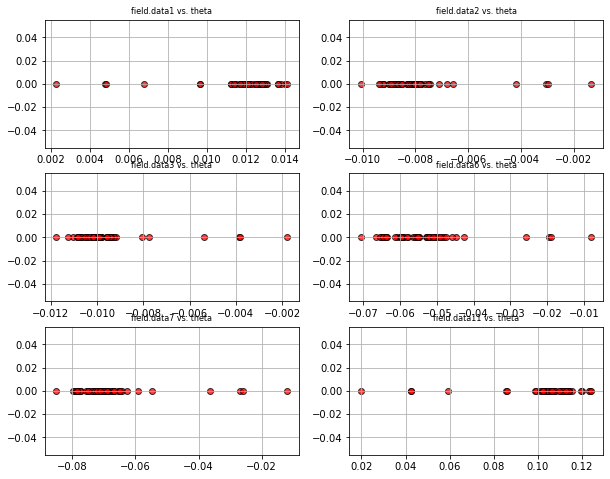

In [10]:
# Visualize data
fig,ax = plt.subplots(3,2,figsize=(10,8))
ax = ax.ravel()
visual_key = 0
for i in range(6):
    ax[i].scatter(aoa_sig[visual_key][aoa_sig[visual_key].columns[i]],aoa_sig[visual_key]['theta'],edgecolor='k',color='red',alpha=0.75)
    ax[i].set_title(f"{aoa_sig[visual_key].columns[i]} vs. theta",fontsize=8)
    ax[i].grid(True)
plt.show()

## Training
### SVR
Here is scikit-learn's SVR doc: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

In [11]:
X = Xaoa.drop('theta', axis=1)
y = Xaoa['theta']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
'''
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)
'''

'\nsc = StandardScaler()\nX_train = sc.fit_transform(X_train)\nX_test = sc.fit_transform(X_test)\n'

### Kernal arg: 'rbf' vs 'sigmoid' vs 'linear'

In [14]:
# Support vector regressor with Gaussian (Radial Basis Function) kernel
svr_1 = SVR(kernel='rbf',gamma='scale', C=2.0, epsilon=0.3)
svr_1.fit(X_train, y_train) 

SVR(C=2.0, epsilon=0.3)

In [15]:
svr_1.score(X_test,y_test)

0.493891147196585

In [16]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_1.predict(X_test))))

RMSE for RBF kernelized SVR: 0.27839961182069933


In [17]:
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
grid = GridSearchCV(svr_1,param_grid=params,cv=5,scoring='r2',verbose=1,return_train_score=True)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=SVR(C=2.0, epsilon=0.3),
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 5],
                         'epsilon': [0.1, 0.2, 0.5, 1]},
             return_train_score=True, scoring='r2', verbose=1)

In [18]:
grid.best_estimator_

SVR(C=5)

In [19]:
svr_best=SVR(kernel='rbf',gamma='scale', C=5.0, epsilon=0.3)
svr_best.fit(X_train, y_train)
svr_best.score(X_test, y_test)

0.5076006284419123

In [20]:
print("RMSE for RBF kernelized SVR:",np.sqrt(mean_squared_error(y_test, svr_best.predict(X_test))))

RMSE for RBF kernelized SVR: 0.2746030795688882


### MLP ANN

In [21]:
le = LabelEncoder()

In [22]:
sc = StandardScaler()

In [23]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)
X_test_std

array([[ 0.45026766,  0.30255835, -0.57178912,  0.59606588, -0.26152514,
         0.50236897],
       [ 0.16940492,  0.10540882, -0.49521683,  0.27085307, -0.31373996,
         0.23948801],
       [ 0.43408546, -0.72025514, -0.08641286, -0.76590055, -0.10239175,
         0.40075212],
       [ 0.33812603,  0.38308482, -0.49196929,  0.67929118, -0.16376609,
         0.3913302 ],
       [ 0.37069437, -0.00981556, -0.69661641,  0.1679969 , -0.52980417,
         0.4546753 ],
       [-3.2019296 ,  2.92021535,  3.05728741,  2.56627193,  3.12752696,
        -3.18235668],
       [ 0.15264404, -0.62494042,  0.00371676, -0.83571669, -0.38826682,
         0.06247212],
       [ 0.47416078, -0.90203496, -0.200159  , -1.07555947, -0.51321213,
         0.38509311],
       [-1.87630342,  1.95910299,  1.71782722,  1.85973735,  1.89759421,
        -1.82807645],
       [ 0.75563138, -0.35684164, -1.08975448, -0.08739779, -0.87069726,
         0.83474397],
       [ 0.40900924,  0.31259116, -0.52537185,  0.

In [24]:
y_train_std = le.fit_transform(y_train)
y_test_std = le.fit_transform(y_test)
y_test_std

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0])

In [25]:
mlpr = MLPRegressor(hidden_layer_sizes=4, random_state=1, max_iter=500)
mlpr.fit(X_train_std, y_train_std)

/home/zdai/anaconda3/envs/DLpy37/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(hidden_layer_sizes=4, max_iter=500, random_state=1)

## Autoencoder + FC

## DNN!